In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

from IPython.core.display import display, HTML
from IPython.core.magic import register_cell_magic, register_line_cell_magic, register_line_magic
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings("ignore")

sns.set_style("white")
sns.set_color_codes()

# set default plot settings
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['figure.titlesize'] = 24

# Read Data using Spark SQL API

(Note: Ths notebook is adapted from https://docs.databricks.com/spark/latest/mllib/binary-classification-mllib-pipelines.html)

The dataset we are going to use is publicly available at the UCI Machine Learning Repository (https://archive.ics.uci.edu/ml/datasets/Adult). This data derives from census data, and consists of information about 48842 adult individuals and their annual income. We will use this information to predict if an individual earns >50k a year or <=50K a year. The dataset is rather clean, and consists of both numeric and categorical variables.

### Attribute Information:

* age: continuous
* workclass: Private,Self-emp-not-inc, Self-emp-inc, Federal-gov, Local-gov, State-gov, Without-pay, Never-worked
* fnlwgt: The weights on the CPS files are controlled to independent estimates of the civilian noninstitutional population of the US. People with similar demographic characteristics should have similar weights (continuous).
* education: Bachelors, Some-college, 11th, HS-grad, Prof-school, Assoc-acdm, Assoc-voc...
* education-num: continuous
* marital-status: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent...
* occupation: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners...
* relationship: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried
* race: White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other, Black
* sex: Female, Male
* capital-gain: continuous
* capital-loss: continuous
* hours-per-week: continuous
* native-country: United-States, Cambodia, England, Puerto-Rico, Canada, Germany...
* Target/Label: - <=50K, >50K


It is stored in HDFS as a CSV file at: `/data/adult.data`

In [2]:
from pyspark.sql.types import StructType

schema = StructType().add('age', 'integer') \
                    .add('workclass', 'string') \
                    .add('fnlwgt', 'double') \
                    .add('education', 'string') \
                    .add('education_num', 'double') \
                    .add('marital_status', 'string') \
                    .add('occupation', 'string') \
                    .add('relationship', 'string') \
                    .add('race', 'string') \
                    .add('sex', 'string') \
                    .add('capital_gain', 'double') \
                    .add('capital_loss', 'double') \
                    .add('hours_per_week', 'double') \
                    .add('native_country', 'string') \
                    .add('income_class', 'string') \

census_data = spark.read.option('header', False).option('inferSchema', False) \
    .csv('/data/adult.data', schema=schema, ignoreLeadingWhiteSpace=True)
census_data.printSchema()
census_data.cache()
census_data.limit(10).toPandas()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income_class: string (nullable = true)



age         workclass    fnlwgt  education  education_num  \
0   39         State-gov   77516.0  Bachelors           13.0   
1   50  Self-emp-not-inc   83311.0  Bachelors           13.0   
2   38           Private  215646.0    HS-grad            9.0   
3   53           Private  234721.0       11th            7.0   
4   28           Private  338409.0  Bachelors           13.0   
5   37           Private  284582.0    Masters           14.0   
6   49           Private  160187.0        9th            5.0   
7   52  Self-emp-not-inc  209642.0    HS-grad            9.0   
8   31           Private   45781.0    Masters           14.0   
9   42           Private  159449.0  Bachelors           13.0   

          marital_status         occupation   relationship   race     sex  \
0          Never-married       Adm-clerical  Not-in-family  White    Male   
1     Married-civ-spouse    Exec-managerial        Husband  White    Male   
2               Divorced  Handlers-cleaners  Not-in-family  White    Male   
3     Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4     Married-civ-spouse     Prof-specialty           Wife  Black  Female   
5     Married-civ-spouse    Exec-managerial           Wife  White  Female   
6  Married-spouse-absent      Other-service  Not-in-family  Black  Female   
7     Married-civ-spouse    Exec-managerial        Husband  White    Male   
8          Never-married     Prof-specialty  Not-in-family  White  Female   
9     Married-civ-spouse    Exec-managerial        Husband  White    Male   

   capital_gain  capital_loss  hours_per_week native_country income_class  
0        2174.0           0.0            40.0  United-States        <=50K  
1           0.0           0.0            13.0  United-States        <=50K  
2           0.0           0.0            40.0  United-States        <=50K  
3           0.0           0.0            40.0  United-States        <=50K  
4           0.0           0.0            40.0           Cuba        <=50K  
5           0.0           0.0            40.0  United-States        <=50K  
6           0.0           0.0            16.0        Jamaica        <=50K  
7           0.0           0.0            45.0  United-States         >50K  
8       14084.0           0.0            50.0  United-States         >50K  
9        5178.0           0.0            40.0  United-States         >50K

# Lazy EDA

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f82043d3eb8>,
      dtype=object)

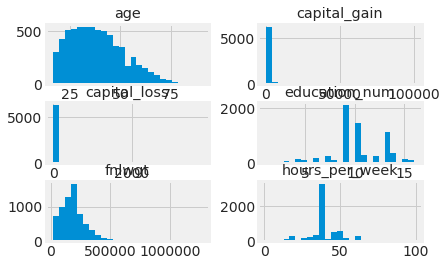

In [3]:
subset = census_data.sample(fraction=0.2, withReplacement=False).toPandas()
subset.hist(bins=25)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8203de8358>,
      dtype=object)

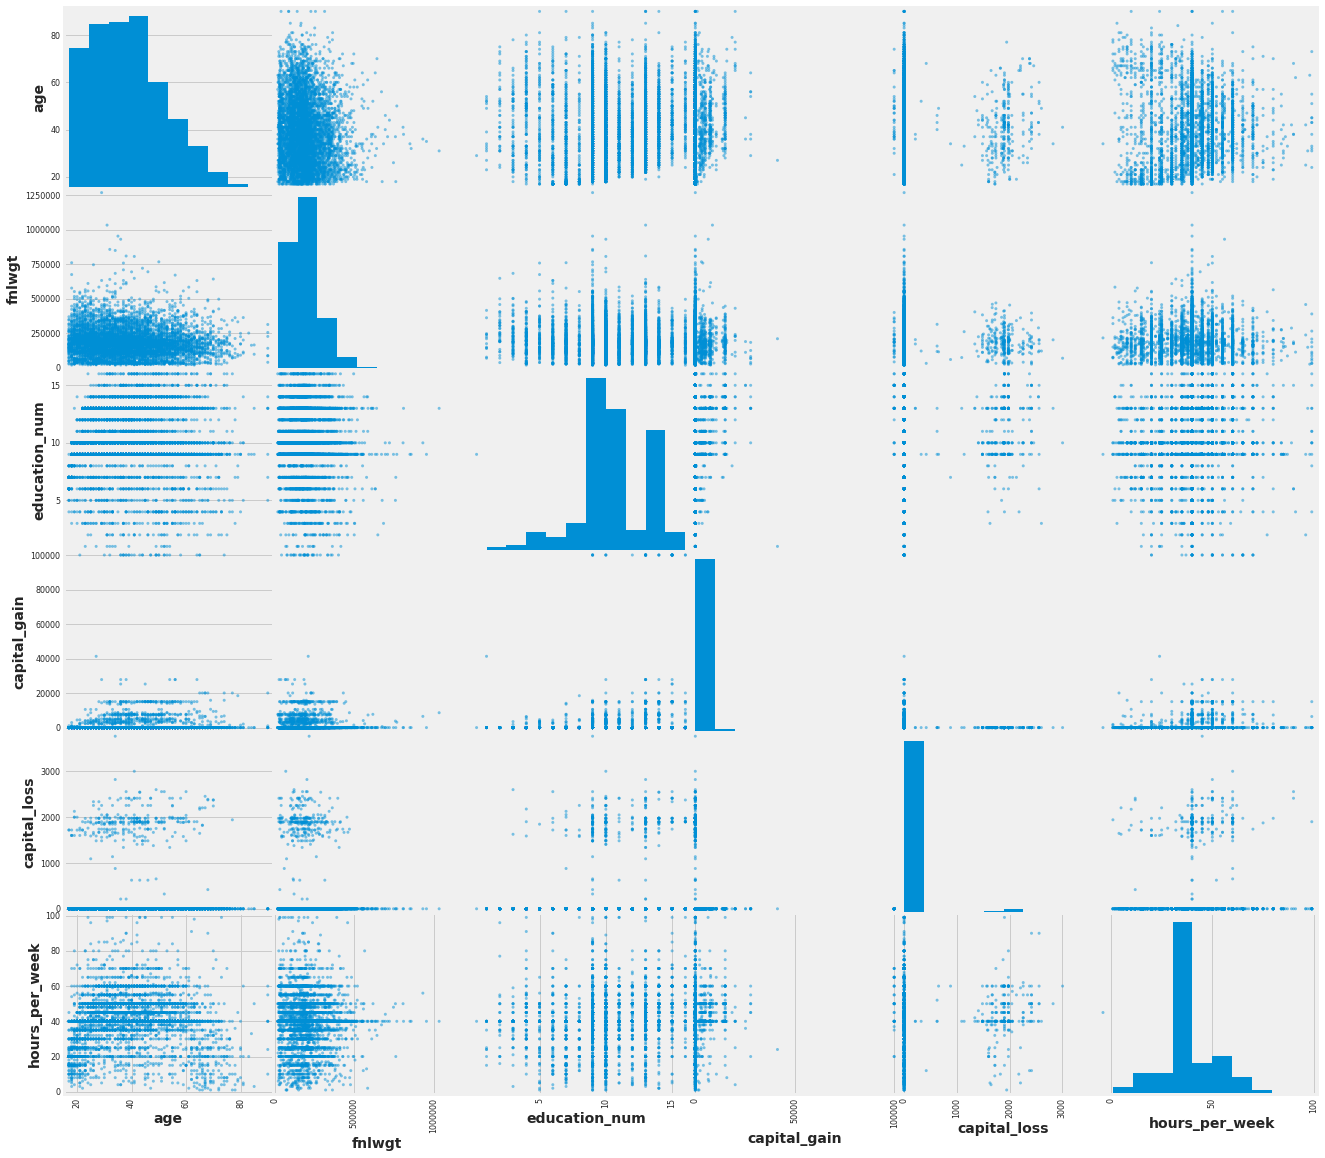

In [4]:
from pandas.plotting import scatter_matrix
scatter_matrix(subset, figsize=(20, 20))

# Preparing the Data

__Goal__: Predict whether income exceeds $50K/yr based on census data.


## Engineering Features from Categorical Data
In order to use all the data for our machine learning algorithms, we will have to convert the categorical variables in the dataset into numeric variables.

### Category Indexing
This is basically assigning a numeric value to each category from {0, 1, 2, ...numCategories-1}. *This introduces an implicit ordering among your categories, and is more suitable for ordinal variables (eg: Poor: 0, Average: 1, Good: 2)*.

We can use __StringIndexer__ for this.

### One-Hot Encoding
This converts categories into binary vectors with at most one nonzero value (eg: (Blue: [1, 0]), (Green: [0, 1]), (Red: [0, 0])).

For simplicity we will not distinguish between ordinal and non-ordinal categorical variables.

In [5]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

categoricalColumns = ["workclass", "education", "marital_status", \
                      "occupation", "relationship", "race", "sex", "native_country"]

stages = [] # stages in our Pipeline
for categoricalCol in categoricalColumns:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoder(inputCol=stringIndexer.getOutputCol(), outputCol=categoricalCol + "classVec")
    
    # Add stages.
    stages += [stringIndexer, encoder]
    
# Convert label into label indices using the StringIndexer
label_stringIdx = StringIndexer(inputCol="income_class", outputCol="label")
stages += [label_stringIdx]

## Adding Numerical Variables and Creating a Single Feature Column

In [6]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in categoricalColumns] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

## Create the Pipeline and Transform then Data

In [7]:
# Create a Pipeline.
pipeline = Pipeline(stages=stages)

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
pipelineModel = pipeline.fit(census_data)
dataset = pipelineModel.transform(census_data)

# Keep relevant columns
selectedcols = ["label", "features"] + census_data.columns
dataset = dataset.select(selectedcols)

dataset.printSchema()
dataset.select('label', 'features').limit(20).toPandas()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income_class: string (nullable = true)



label                                           features
0     0.0  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
1     0.0  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2     0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
3     0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4     0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
5     0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
6     0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
7     1.0  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
8     1.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
9     1.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
10    1.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
11    1.0  (0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
12    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
13    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
14    1.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
15    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
16    0.0  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
17    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
18    0.0  (1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
19    1.0  (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...

## Bonus: Check How Seperable the Data is

Remember, we are interested in questions such as: Is the data linearly seperable? How many 'cuts' are needed to seperate the date?

We use PCA (Principal Component Analysis) to project the multi-dimensional feature vectors into 2D. PCA identified  orthogonal dimensions of greatest variability in the data. Basically this is a best-possible seperation using only two dimensions. But our algorithms will be able to work in all dimensions, so this is only an indicator if the data is well-seperable, not exact.

In [8]:
from pyspark.ml.feature import PCA, VectorSlicer
from pyspark.sql.functions import udf, col
from pyspark.sql.types import DoubleType 

def vector_to_double(vec):
    return float(vec.toArray()[0])

pca = PCA(k=2, inputCol="features", outputCol="pcaFeatures")
slicer_x = VectorSlicer(inputCol=pca.getOutputCol(), outputCol='x', indices=[0])
slicer_y = VectorSlicer(inputCol=pca.getOutputCol(), outputCol='y', indices=[1])

pca_pipeline = Pipeline(stages=[pca, slicer_x, slicer_y])

pca_model = pca_pipeline.fit(dataset)
pca_transform = pca_model.transform(dataset)

vec_to_double_udf = udf(vector_to_double, DoubleType())

pca_transform = pca_transform.withColumn('x', vec_to_double_udf('x')) \
                            .withColumn('y', vec_to_double_udf('y'))
pca_transform.select('x', 'y', 'label').show(truncate=False)

+-------------------+-------------------+-----+
|x                  |y                  |label|
+-------------------+-------------------+-----+
|-77516.06543269008 |-2171.6489926882596|0.0  |
|-83310.99935524586 |2.526012592021478  |0.0  |
|-215645.99925037424|6.551846307329748  |0.0  |
|-234720.99907984014|7.130289027845617  |0.0  |
|-338408.99918853625|10.289239740783078 |0.0  |
|-284581.99916641274|8.649746109926623  |0.0  |
|-160186.99926990306|4.865759947493696  |0.0  |
|-209641.99910779952|6.366436719217544  |1.0  |
|-45781.42721097387 |-14082.596950632678|1.0  |
|-159449.15652298174|-5173.151354813888 |1.0  |
|-280463.9990886714 |8.519343864892539  |1.0  |
|-141296.99942029396|4.290077470568214  |1.0  |
|-122271.9995362032 |3.7134180642650167 |0.0  |
|-205018.99929899204|6.22784947648439   |0.0  |
|-121771.99934861792|3.69451734830086   |1.0  |
|-245486.99924637936|7.460137941997898  |0.0  |
|-176755.99943970316|5.370798108708459  |0.0  |
|-186823.9993468446 |5.675548079787834  

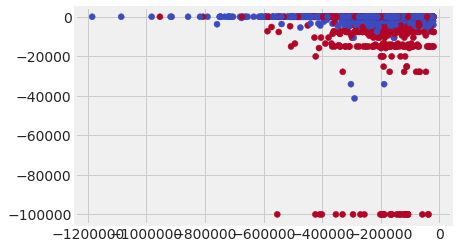

In [9]:
pca_subset = pca_transform.sample(fraction=0.2, withReplacement=False).toPandas()
plt.scatter(pca_subset.x, pca_subset.y, c=pca_subset.label / 2., cmap='coolwarm')

## Randomly Split Data into Training and Test Sets

In [10]:
# Randomly split data into training and test sets.
(training, test) = dataset.randomSplit([0.7, 0.3])
print(training.count())
print(test.count())

22896
9665


# Fit and Evaluate Models

These are the general steps we will take to build our models:

Create initial model using the training set
Tune parameters with a ParamGrid and TrainValidationSplit
Evaluate the best model obtained from the tuning using the test set

We use the BinaryClassificationEvaluator to evaluate our models, which uses areaUnderROC as the default metric.

## Logistic Regression

Setup a logistic regression estimator, a binary classification evaluator, a parameter grid, and a TrainValidationSplit.

Parameters:
* regParam: 0.01, 0.5, 2.0
* elasticNetParam: 0.0, 0.5, 1.0
* maxIter: 1, 5, 10

In [11]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Create LogisticRegression model
lr = LogisticRegression(labelCol="label", featuresCol="features")

# Create Evaluator
evaluator = BinaryClassificationEvaluator(labelCol=lr.getLabelCol(), \
                rawPredictionCol=lr.getRawPredictionCol())

# Create ParamGrid for Cross Validation
paramGrid = ParamGridBuilder() \
             .addGrid(lr.regParam, [0.01, 0.5, 2.0]) \
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]) \
             .addGrid(lr.maxIter, [1, 5, 10]) \
             .build()

# Create Model Tuner
tuner = TrainValidationSplit(estimator=lr, estimatorParamMaps=paramGrid, \
                          evaluator=evaluator, trainRatio=0.8)

### Tune the Logistic Regression Model and Evaluate the best Model on the Test-Set.

In [12]:
best_model = tuner.fit(training)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

# Use test set to measure the accuracy of our model on new data
predictions = best_model.transform(test)

# Evaluate best model
print(evaluator.getMetricName() + (": %g" % evaluator.evaluate(predictions)))

areaUnderROC: 0.90069


## Decision Tree

Setup a decision tree estimator, a parameter grid, and a TrainValidationSplit.

Parameters:
* maxDepth: 1, 2, 6, 10
* maxBins: 20, 40, 80

In [13]:
from pyspark.ml.classification import DecisionTreeClassifier

# Create Decision Tree Model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features")

paramGrid_dt = ParamGridBuilder() \
             .addGrid(dt.maxDepth, [1, 2, 6, 10]) \
             .addGrid(dt.maxBins, [20, 40, 80]) \
             .build()
            
tuner_dt = TrainValidationSplit(estimator=dt, estimatorParamMaps=paramGrid_dt, \
                          evaluator=BinaryClassificationEvaluator(), trainRatio=0.8)

### Tune the Decision Tree Model and Evaluate the best Model on the Test-Set.

In [14]:
best_model_dt = tuner_dt.fit(training)

predictions_dt = best_model_dt.transform(test)

print(tuner_dt.getEvaluator().getMetricName() + (": %g" % tuner_dt.getEvaluator().evaluate(predictions_dt)))
print("numNodes = ", best_model_dt.bestModel.numNodes)
print("depth = ", best_model_dt.bestModel.depth)

areaUnderROC: 0.785532
numNodes =  491
depth =  10


## Random Forrest

Setup a random forrest estimator, a parameter grid, and a TrainValidationSplit.

Parameters:
* maxDepth: 2, 4, 6
* maxBins: 20, 60
* numTrees: 5, 20

In [15]:
from pyspark.ml.classification import RandomForestClassifier

# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features")

paramGrid_rf = ParamGridBuilder() \
             .addGrid(rf.maxDepth, [2, 4, 6]) \
             .addGrid(rf.maxBins, [20, 60]) \
             .addGrid(rf.numTrees, [5, 20]) \
             .build()
                
tuner_rf = TrainValidationSplit(estimator=rf, estimatorParamMaps=paramGrid_rf, \
                          evaluator=BinaryClassificationEvaluator(), trainRatio=0.8)

### Tune the Random Forrest Model and Evaluate the best Model on the Test-Set.

In [16]:
best_model_rf = tuner_rf.fit(training)

predictions_rf = best_model_rf.transform(test)

print(tuner_rf.getEvaluator().getMetricName() + (": %g" % tuner_rf.getEvaluator().evaluate(predictions_rf)))
print(best_model_rf.bestModel)

areaUnderROC: 0.901327
RandomForestClassificationModel (uid=rfc_2615ecee9ffe) with 20 trees
